In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from astropy.table import Table
import pickle
import pandas as pd
import SyntheticData as sd
import Sampler
from datetime import datetime, date

/home/bepennell/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Preamble

In [6]:
indices = [0,5,7,9,12]
working_catalogue = []
relevant_list = ["parallax", "mass", "solution_type"]

mdwarfs = Table.read('./data/200pc_mdwarfs_reduced.fits', format='fits')
masses = np.array([row["mass_single"] for row in mdwarfs])
percs = np.percentile(masses, np.arange(0, 110, 10))
for row in tqdm(mdwarfs):
    df = dict()
    df["soltype_index"] = indices.index(row["solution_type"])   
    df["mass_index"] = np.minimum(np.digitize(row["mass_single"], percs) - 1, 9)
    for item in relevant_list:
        working_item = item
        if item == "mass":
            working_item = "mass_single"
        df[item] = float(row[working_item])
    working_catalogue.append(df)
working_catalogue = np.array(working_catalogue)

  0%|          | 0/225536 [00:00<?, ?it/s]

In [10]:
percentiles = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
masses = np.array([t["mass"] for t in working_catalogue])
mass_lims = np.percentile(masses, percentiles) 
def convert_to_usable(sc_cubes, mass_index):
    target_mass = sc_cubes["meta"]["reference_masses"][mass_index]
    
    out_sc_cube = {}
    out_sc_cube["data"] = sc_cubes["data"][target_mass]
    out_sc_cube["meta"] = {}
    out_sc_cube["meta"]["shape"] = sc_cubes["meta"]["shape"]
    out_sc_cube["meta"]["lambdas"] = np.array(sc_cubes["meta"]["lambdas"][mass_index])
    out_sc_cube["meta"]["periods"] = sc_cubes["meta"]["periods"]
    out_sc_cube["meta"]["parallaxes"] = sc_cubes["meta"]["parallaxes"]
    
    out_catalogue = []
    for i in range(3):
        out_catalogue = out_catalogue + sc_cubes["meta"]["memory_reduced_catalogue"][mass_index][i]

    # pull out only what we need
    memory_reduced = []
    relevant_list = ["parallax", "mass", "solution_type", "phot_g_mean_mag"]
    for row in out_catalogue: 
        df = dict()
        for item in relevant_list:
            working_item = item
            if item == "mass":
                working_item = "mass_single"
            df[item] = float(row[working_item])
        memory_reduced.append(df)
    
    return out_sc_cube, memory_reduced

def mass_binned_data(sc_cubes, catalogue, mass_binned=False, p_model=(4,2), q_model=0, model_cube_size=(15,15), scale=5):
    synth_results = []

    for mass_index in tqdm(range(len(mass_lims))):
        temp_catalogue = []
        for _, obj in enumerate(catalogue):
            if mass_index == 0:
                if obj["mass"] < mass_lims[0]:
                    temp_catalogue.append(obj)
            else:
                if (mass_lims[mass_index-1] < obj["mass"]) & (obj["mass"] < mass_lims[mass_index]):
                    temp_catalogue.append(obj)
        
        # reduce to only mandatory objects to save on memory
        working_catalogue = []
        relevant_list = ["parallax", "mass", "solution_type"]
        for row in temp_catalogue:
            df = dict()
            df["mass_index"] = mass_index
            for item in relevant_list:
                df[item] = float(row[item])
            working_catalogue.append(df)
        
        model_cube = Sampler.create_model_cube(model_cube_size, p_model=p_model, q_model=q_model)
        out_sc_cube = sc_cubes
        if mass_binned:
            out_sc_cube, _ = convert_to_usable(sc_cubes, mass_index)
        synthsampler = Sampler.popsampler(out_sc_cube, working_catalogue, model_cube=model_cube)
        _, _ = synthsampler.binarity(resolution=1000, scale=scale, verbose=False)
        synth_results.append(synthsampler.fb_estimator())
        print(f'{synthsampler.fb_estimator()[0]*100:.2f}')
    synth_results = np.array(synth_results)
    return synth_results

def generate_plot(synth_results, target_fb=None):
    plt.errorbar(mass_lims, synth_results[:,0], yerr=(synth_results[:,2], synth_results[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
    plt.scatter(mass_lims, synth_results[:,0], marker='o', zorder=2);
    if target_fb is not None:
        plt.axhline(y=target_fb, c="green", linestyle="--");

In [11]:
sc_cubes = pickle.load(open("./data/2026-01-16-mdwarf_mbins_3plx_turnover.pkl", "rb"))
synth_results = mass_binned_data(sc_cubes, working_catalogue, mass_binned=True, p_model=(4,1.3), q_model=0.5, model_cube_size=(35,25), scale=3)

  0%|          | 0/10 [00:00<?, ?it/s]

13.72
17.57
20.55
21.89
22.08
24.01
26.41
26.12
25.54
24.39


In [18]:
outdata = dict()
outdata["meta"] = dict()
outdata["notes"] = "2026.01.23 Real data. Mass binned results for mdwarfs with parallax cuts and 3-parameter luminosity function with turnover. p=(4,1.3), q=0.5, model cube size (25,15), scale=2."
outdata["data"] = dict()
outdata["data"] = synth_results

outfile = open(f'./plot_data/{date.today()}-real_data.pkl', "wb")
pickle.dump(outdata, outfile)
outfile.close()

In [3]:
synth_results = pickle.load(open("./plot_data/2026-01-23-real_data.pkl", "rb"))["data"]

In [4]:
import style

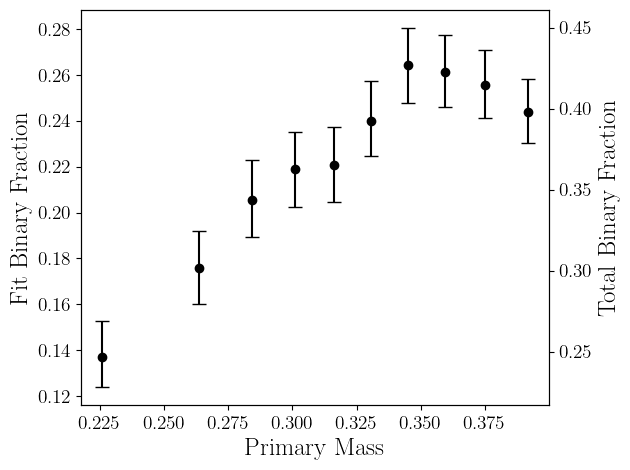

In [7]:
a = Sampler.area_in_range_powerlaw((0.05,1), 0)/Sampler.area_in_range_powerlaw((0.05,0.5), 0)
percentiles_b = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])-10
masses = np.array([t["mass_single"] for t in mdwarfs])
mass_lims_b = np.percentile(masses, percentiles_b)
bin_centers = (mass_lims_b[1:] + mass_lims_b[:-1]) / 2

plt.errorbar(bin_centers, synth_results[:,0], yerr=(synth_results[:,2], synth_results[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
plt.scatter(bin_centers, synth_results[:,0], marker='o', c="k", zorder=2);
plt.xlabel("Primary Mass");
plt.ylabel("Fit Binary Fraction");
ymin, ymax = plt.ylim()
ax = plt.twinx();
ax.set_ylim(Sampler.convert_binarity(ymin, a), Sampler.convert_binarity(ymax, a));
ax.set_ylabel("Total Binary Fraction");
plt.tight_layout();
plt.savefig("./plots/2026-01-23-real_data.png", dpi=800)